# IMPORTS

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import ast
from sklearn.model_selection import StratifiedKFold, cross_validate, cross_val_predict
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
from tqdm import tqdm
from scipy.signal import find_peaks
from scipy.signal import savgol_filter



# DATA RETRIEVAL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
BASE_DIR = "/content/drive/MyDrive/DSAIP/dataset/"
MODEL_DIR = "/content/drive/MyDrive/DSAIP/streamlit/models/"
LEFT_HAND_DIR = os.path.join(BASE_DIR, "left")
RIGHT_HAND_DIR = os.path.join(BASE_DIR, "right")
#UPDRS_DIR = os.path.join(BASE_DIR, "csv")
UPDRS_FILE = os.path.join(BASE_DIR, "updrs_scores.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load UPDRS Scores
updrs_df = pd.read_csv(UPDRS_FILE)
updrs_df.head()

,patient,updrs_right,updrs_left
0,PD0,0,0
1,PD1,1,1
2,PD2,0,0
3,PD3,1,1
4,PD4,0,0


In [ ]:
#Helper Function to Read Signal Files
def read_signal_file(file_path):
    with open(file_path, "r") as f:
        values = [float(line.strip()) for line in f if line.strip()]
    return values

# DATA WRANGLING

 LEFT HAND DATA PREPARATION

In [ ]:
#Process Left Hand Data
left_records = []

for patient_folder in os.listdir(LEFT_HAND_DIR):
    patient_path = os.path.join(LEFT_HAND_DIR, patient_folder)
    # print(patient_path)

    if not os.path.isdir(patient_path):
        continue

    patient_id = patient_folder

    file_text_path = os.path.join(patient_path, "Text files")
    amplitude_path = os.path.join(file_text_path, "Amplitude.txt")
    time_path = os.path.join(file_text_path, "Time.txt")

    if not os.path.exists(amplitude_path) or not os.path.exists(time_path):
        continue

    amplitude_values = read_signal_file(amplitude_path)
    time_values = read_signal_file(time_path)

    updrs_value = updrs_df.loc[
        updrs_df["patient"] == patient_id, "updrs_left"
    ].values

    # if len(updrs_value) == 0:
    #     continue

    updrs_value = updrs_value[0]

    left_records.append({
        "patient_id": patient_id,
        "updrs_left": updrs_value,
        "amplitude": amplitude_values,
        "time": time_values
    })






In [ ]:
#Create Left Hand DataFrame, Pad to 1800 values and Save CSV
left_df = pd.DataFrame(left_records)

# Create target column: 1 = Parkinson's, 0 = Healthy
left_df["target"] = left_df["patient_id"].apply(lambda x: 1 if x.startswith("PD") else 0)

TARGET_LEN = 1800

def pad_signal(amplitude, time, target_len=TARGET_LEN):
    amplitude = np.array(amplitude)
    time = np.array(time)

    # Pad amplitude with last value
    if len(amplitude) < target_len:
        pad_width = target_len - len(amplitude)
        amplitude = np.pad(amplitude, (0, pad_width), mode='edge')

    # Pad time with 30.0
    if len(time) < target_len:
        pad_width = target_len - len(time)
        time = np.pad(time, (0, pad_width), constant_values=30.0)

    return amplitude.tolist(), time.tolist()

# Apply to each row
for idx, row in left_df.iterrows():
    amplitude_padded, time_padded = pad_signal(row['amplitude'], row['time'])
    left_df.at[idx, 'amplitude'] = amplitude_padded
    left_df.at[idx, 'time'] = time_padded


left_csv_path = os.path.join(BASE_DIR, "left_hand_dataset.csv")

left_df.to_csv(left_csv_path, index=False)

In [ ]:
# Check first row
first_row = left_df.iloc[0]

amplitude_len = len(first_row['amplitude'])
time_len = len(first_row['time'])

print(f"First row amplitude length: {amplitude_len}")
print(f"First row time length: {time_len}")



First row amplitude length: 1800
First row time length: 1800


LEFT HAND EXPLORATORY DATA ANALYSIS.

In [ ]:
#Basic Statistics
left_df.head()

,patient_id,updrs_left,amplitude,time,target
0,C35,0,"[0.7659240331883278, 0.8466510181877207, 0.883...","[0.03333333333333333, 0.05, 0.0666666666666666...",0
1,C34,0,"[0.851907050083096, 0.8627108573966841, 0.8671...","[0.016666666666666666, 0.03333333333333333, 0....",0
2,C36,0,"[0.8699220059481613, 0.8954643663407749, 0.915...","[0.03333333333333333, 0.05, 0.0666666666666666...",0
3,PD0,0,"[0.1218324818522516, 0.11758457712459694, 0.12...","[0.016666666666666666, 0.03333333333333333, 0....",1
4,C37,0,"[0.24363131117259645, 0.29041362353638617, 0.2...","[0.03333333333333333, 0.05, 0.0666666666666666...",0


In [ ]:
left_df.describe()

,updrs_left,target
count,66.000000,66.000000
mean,0.272727,0.924242
std,0.448775,0.266638
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


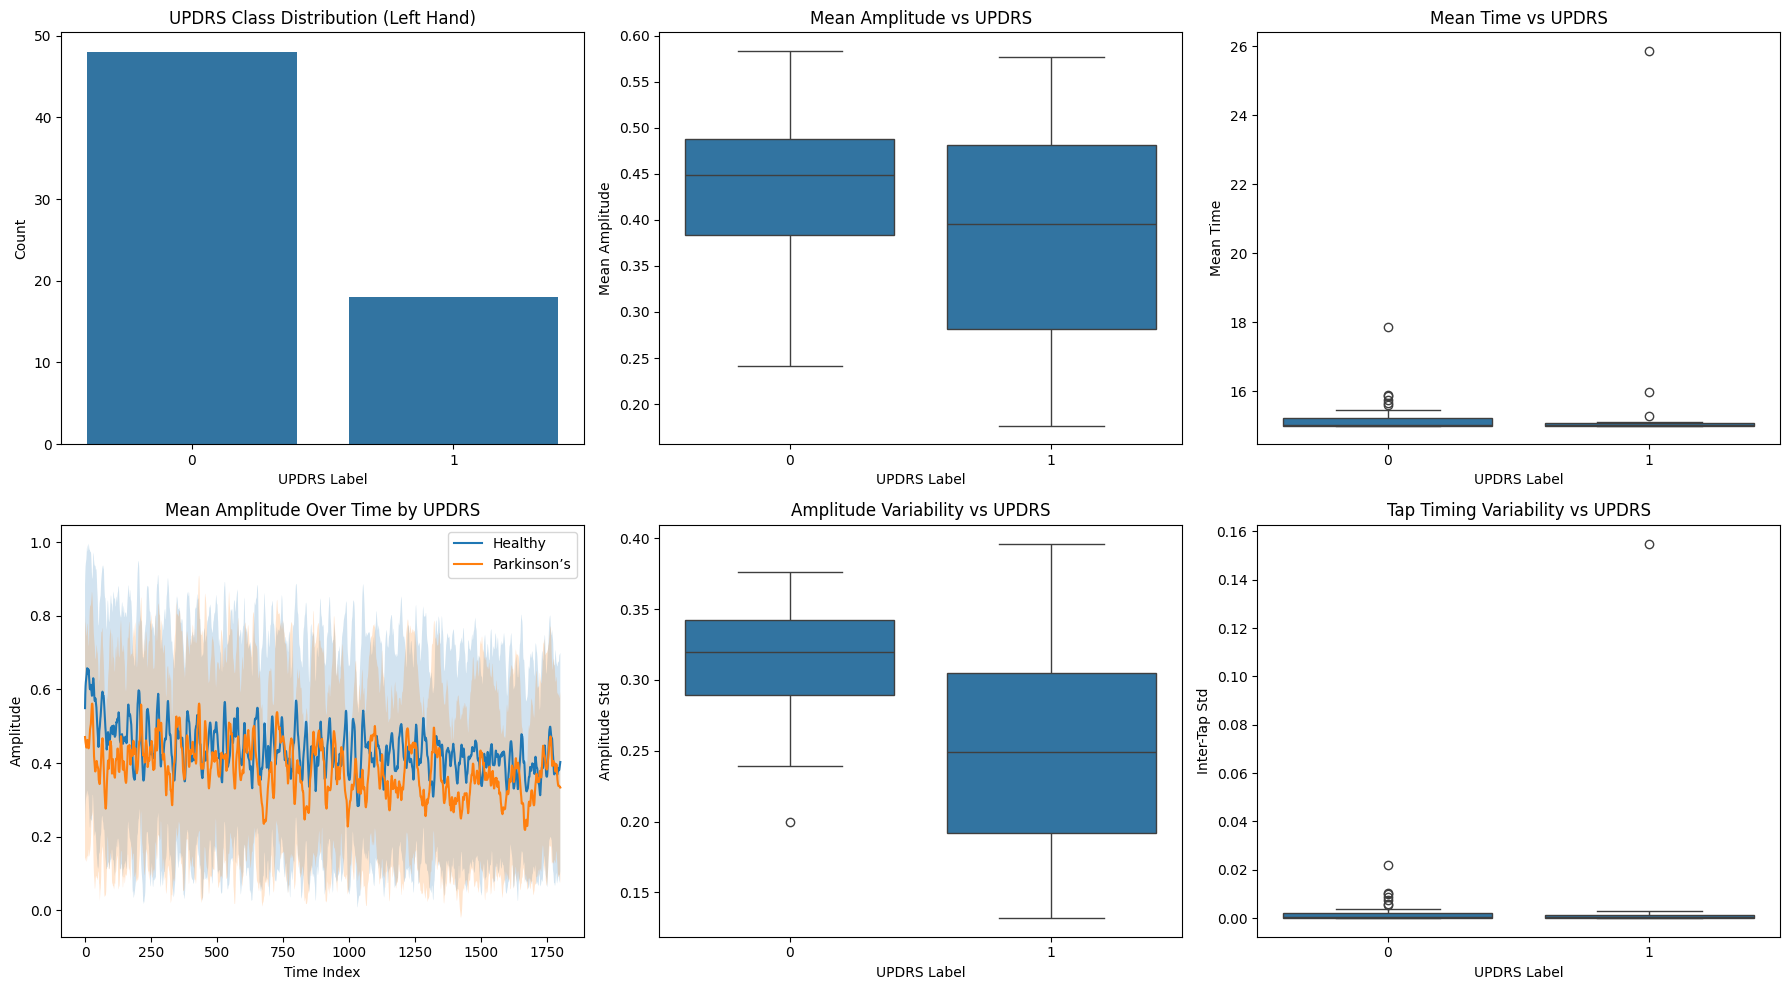

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# -------------------------------
# 1. UPDRS Class Distribution
# -------------------------------
sns.countplot(x="updrs_left", data=left_df, ax=ax[0, 0])
ax[0, 0].set_title("UPDRS Class Distribution (Left Hand)")
ax[0, 0].set_xlabel("UPDRS Label")
ax[0, 0].set_ylabel("Count")

# -------------------------------
# 2. Mean Amplitude vs UPDRS
# -------------------------------
left_amp_means = left_df["amplitude"].apply(np.mean)
sns.boxplot(x=left_df["updrs_left"], y=left_amp_means, ax=ax[0, 1])
ax[0, 1].set_title("Mean Amplitude vs UPDRS")
ax[0, 1].set_xlabel("UPDRS Label")
ax[0, 1].set_ylabel("Mean Amplitude")

# -------------------------------
# 3. Mean Time vs UPDRS
# -------------------------------
left_time_means = left_df["time"].apply(np.mean)
sns.boxplot(x=left_df["updrs_left"], y=left_time_means, ax=ax[0, 2])
ax[0, 2].set_title("Mean Time vs UPDRS")
ax[0, 2].set_xlabel("UPDRS Label")
ax[0, 2].set_ylabel("Mean Time")

# -------------------------------
# 4. Amplitude over Time by UPDRS
# -------------------------------
amp_0 = np.stack(left_df[left_df["updrs_left"] == 0]["amplitude"].values)
amp_1 = np.stack(left_df[left_df["updrs_left"] == 1]["amplitude"].values)

mean_0, std_0 = amp_0.mean(axis=0), amp_0.std(axis=0)
mean_1, std_1 = amp_1.mean(axis=0), amp_1.std(axis=0)

time_axis = np.arange(len(mean_0))

ax[1, 0].plot(time_axis, mean_0, label="Healthy")
ax[1, 0].fill_between(time_axis, mean_0-std_0, mean_0+std_0, alpha=0.2)

ax[1, 0].plot(time_axis, mean_1, label="Parkinson’s")
ax[1, 0].fill_between(time_axis, mean_1-std_1, mean_1+std_1, alpha=0.2)

ax[1, 0].set_title("Mean Amplitude Over Time by UPDRS")
ax[1, 0].set_xlabel("Time Index")
ax[1, 0].set_ylabel("Amplitude")
ax[1, 0].legend()

# -------------------------------
# 5. Amplitude Variability vs UPDRS
# -------------------------------
left_df["amp_std"] = left_df["amplitude"].apply(np.std)
sns.boxplot(x="updrs_left", y="amp_std", data=left_df, ax=ax[1, 1])
ax[1, 1].set_title("Amplitude Variability vs UPDRS")
ax[1, 1].set_xlabel("UPDRS Label")
ax[1, 1].set_ylabel("Amplitude Std")

# -------------------------------
# 6. Tap Timing Variability vs UPDRS
# -------------------------------
def inter_tap_std(time_seq):
    return np.std(np.diff(np.array(time_seq)))

left_df["tap_interval_std"] = left_df["time"].apply(inter_tap_std)
sns.boxplot(x="updrs_left", y="tap_interval_std", data=left_df, ax=ax[1, 2])
ax[1, 2].set_title("Tap Timing Variability vs UPDRS")
ax[1, 2].set_xlabel("UPDRS Label")
ax[1, 2].set_ylabel("Inter-Tap Std")

plt.tight_layout()
plt.show()


RIGHT HAND DATA PREPARATION

In [ ]:
#Process Right Hand Data
right_records = []

for patient_folder in os.listdir(RIGHT_HAND_DIR):
    patient_path = os.path.join(RIGHT_HAND_DIR, patient_folder)
    # print(patient_path)

    if not os.path.isdir(patient_path):
        continue

    patient_id = patient_folder

    file_text_path = os.path.join(patient_path, "Text files")
    amplitude_path = os.path.join(file_text_path, "Amplitude.txt")
    time_path = os.path.join(file_text_path, "Time.txt")

    if not os.path.exists(amplitude_path) or not os.path.exists(time_path):
        continue

    amplitude_values = read_signal_file(amplitude_path)
    time_values = read_signal_file(time_path)

    updrs_value = updrs_df.loc[
        updrs_df["patient"] == patient_id, "updrs_right"
    ].values

    updrs_value = updrs_value[0]

    right_records.append({
        "patient_id": patient_id,
        "updrs_right": updrs_value,
        "amplitude": amplitude_values,
        "time": time_values
    })



#Create Right Hand DataFrame and Save CSV
right_df = pd.DataFrame(right_records)
right_df["target"] = right_df["patient_id"].apply(lambda x: 1 if x.startswith("PD") else 0)

for idx, row in right_df.iterrows():
    amplitude_padded, time_padded = pad_signal(row['amplitude'], row['time'])
    right_df.at[idx, 'amplitude'] = amplitude_padded
    right_df.at[idx, 'time'] = time_padded

right_csv_path = os.path.join(BASE_DIR, "right_hand_dataset.csv")
right_df.to_csv(right_csv_path, index=False)

first_row = right_df.iloc[0]
print(len(first_row['amplitude']), len(first_row['time']))



1800 1800


**📊 RIGHT HAND Exploratory Data Analysis.**

In [ ]:
right_df.head()

,patient_id,updrs_right,amplitude,time,target
0,C35,0,"[0.6530151114143359, 0.6270839361667977, 0.626...","[0.35, 0.43333333333333335, 0.5, 0.55, 0.6, 1....",0
1,C36,0,"[0.5334723765294708, 0.5461395959097487, 0.544...","[0.03333333333333333, 0.05, 0.0666666666666666...",0
2,C37,0,"[0.8328087854564177, 0.8913689193269073, 0.896...","[0.03333333333333333, 0.05, 0.0666666666666666...",0
3,C34,0,"[0.9289948247349404, 0.9592191309322802, 0.964...","[0.016666666666666666, 0.03333333333333333, 0....",0
4,PD10,0,"[0.9742337800899056, 0.947790624557038, 0.9427...","[0.016666666666666666, 0.03333333333333333, 0....",1


In [ ]:
right_df.describe()

,updrs_right,target
count,66.000000,66.000000
mean,0.212121,0.924242
std,0.411943,0.266638
min,0.000000,0.000000
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


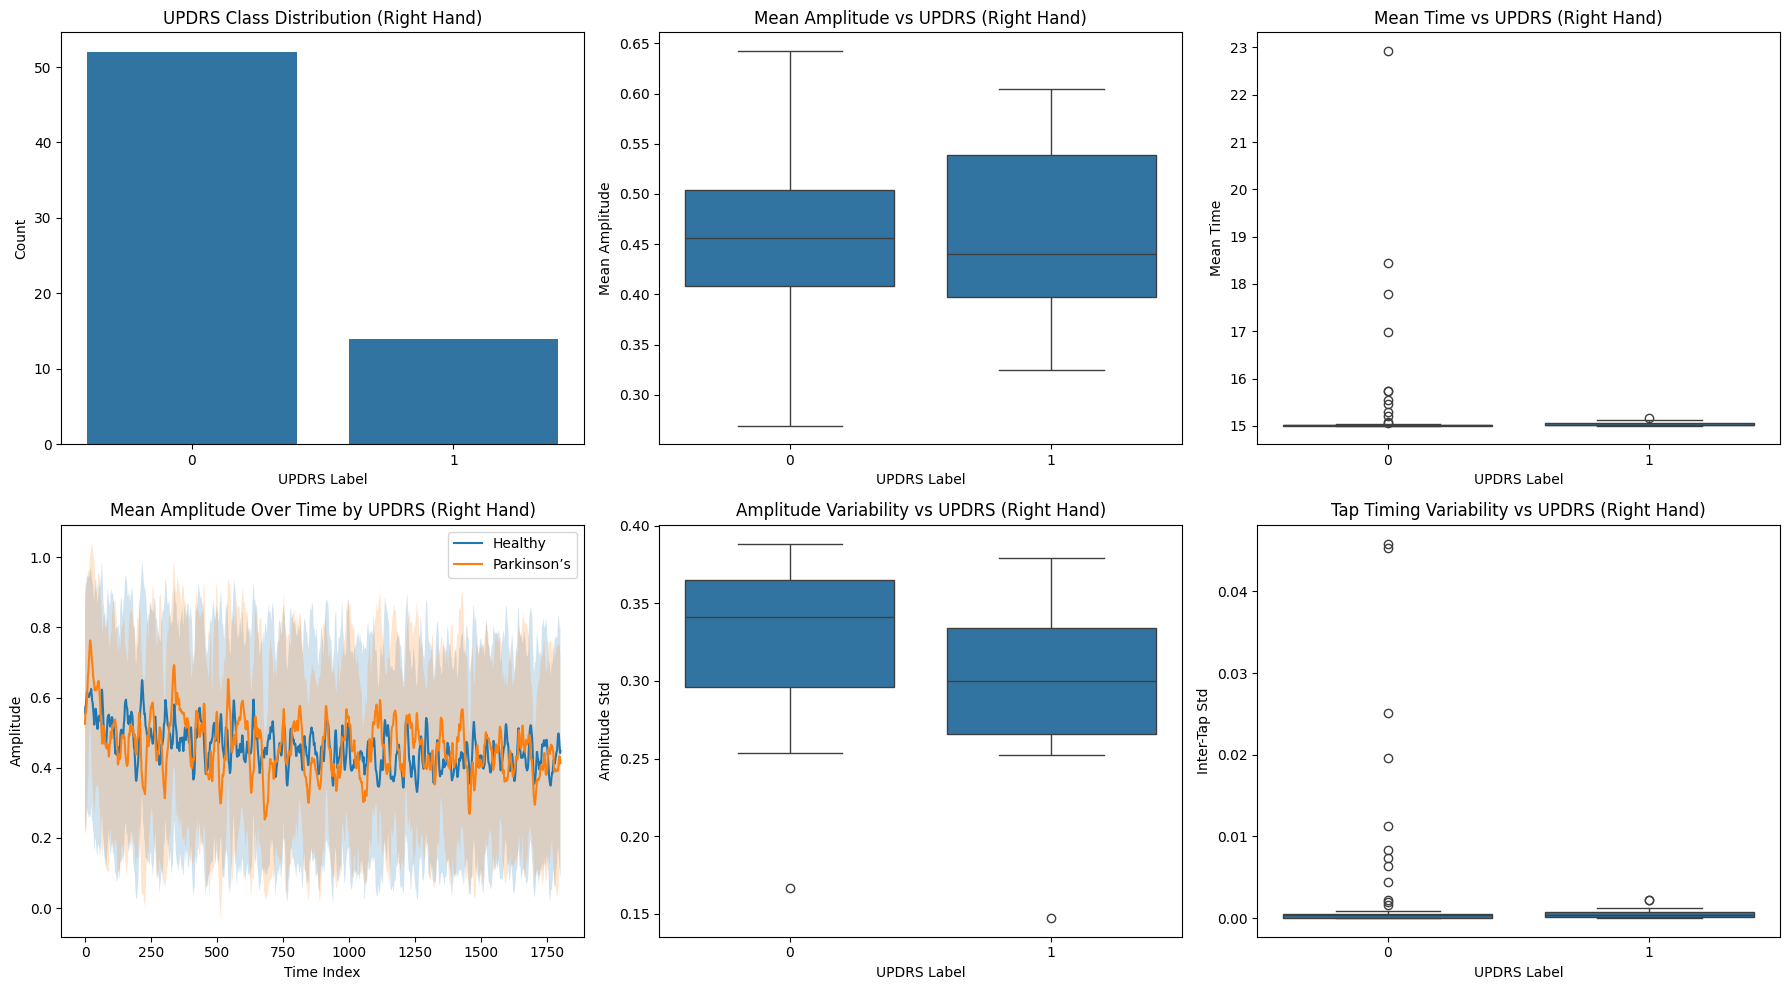

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# -------------------------------
# 1. UPDRS Class Distribution
# -------------------------------
sns.countplot(x="updrs_right", data=right_df, ax=ax[0, 0])
ax[0, 0].set_title("UPDRS Class Distribution (Right Hand)")
ax[0, 0].set_xlabel("UPDRS Label")
ax[0, 0].set_ylabel("Count")

# -------------------------------
# 2. Mean Amplitude vs UPDRS
# -------------------------------
right_amp_means = right_df["amplitude"].apply(np.mean)
sns.boxplot(x=right_df["updrs_right"], y=right_amp_means, ax=ax[0, 1])
ax[0, 1].set_title("Mean Amplitude vs UPDRS (Right Hand)")
ax[0, 1].set_xlabel("UPDRS Label")
ax[0, 1].set_ylabel("Mean Amplitude")

# -------------------------------
# 3. Mean Time vs UPDRS
# -------------------------------
right_time_means = right_df["time"].apply(np.mean)
sns.boxplot(x=right_df["updrs_right"], y=right_time_means, ax=ax[0, 2])
ax[0, 2].set_title("Mean Time vs UPDRS (Right Hand)")
ax[0, 2].set_xlabel("UPDRS Label")
ax[0, 2].set_ylabel("Mean Time")

# -------------------------------
# 4. Amplitude over Time by UPDRS
# -------------------------------
amp_0 = np.stack(right_df[right_df["updrs_right"] == 0]["amplitude"].values)
amp_1 = np.stack(right_df[right_df["updrs_right"] == 1]["amplitude"].values)

mean_0, std_0 = amp_0.mean(axis=0), amp_0.std(axis=0)
mean_1, std_1 = amp_1.mean(axis=0), amp_1.std(axis=0)

time_axis = np.arange(len(mean_0))

ax[1, 0].plot(time_axis, mean_0, label="Healthy")
ax[1, 0].fill_between(time_axis, mean_0 - std_0, mean_0 + std_0, alpha=0.2)

ax[1, 0].plot(time_axis, mean_1, label="Parkinson’s")
ax[1, 0].fill_between(time_axis, mean_1 - std_1, mean_1 + std_1, alpha=0.2)

ax[1, 0].set_title("Mean Amplitude Over Time by UPDRS (Right Hand)")
ax[1, 0].set_xlabel("Time Index")
ax[1, 0].set_ylabel("Amplitude")
ax[1, 0].legend()

# -------------------------------
# 5. Amplitude Variability vs UPDRS
# -------------------------------
right_df["amp_std"] = right_df["amplitude"].apply(np.std)
sns.boxplot(x="updrs_right", y="amp_std", data=right_df, ax=ax[1, 1])
ax[1, 1].set_title("Amplitude Variability vs UPDRS (Right Hand)")
ax[1, 1].set_xlabel("UPDRS Label")
ax[1, 1].set_ylabel("Amplitude Std")

# -------------------------------
# 6. Tap Timing Variability vs UPDRS
# -------------------------------
def inter_tap_std(time_seq):
    return np.std(np.diff(np.array(time_seq)))

right_df["tap_interval_std"] = right_df["time"].apply(inter_tap_std)
sns.boxplot(x="updrs_right", y="tap_interval_std", data=right_df, ax=ax[1, 2])
ax[1, 2].set_title("Tap Timing Variability vs UPDRS (Right Hand)")
ax[1, 2].set_xlabel("UPDRS Label")
ax[1, 2].set_ylabel("Inter-Tap Std")

plt.tight_layout()
plt.show()


**🔄 Comparative Exploratory Data Analysis.**



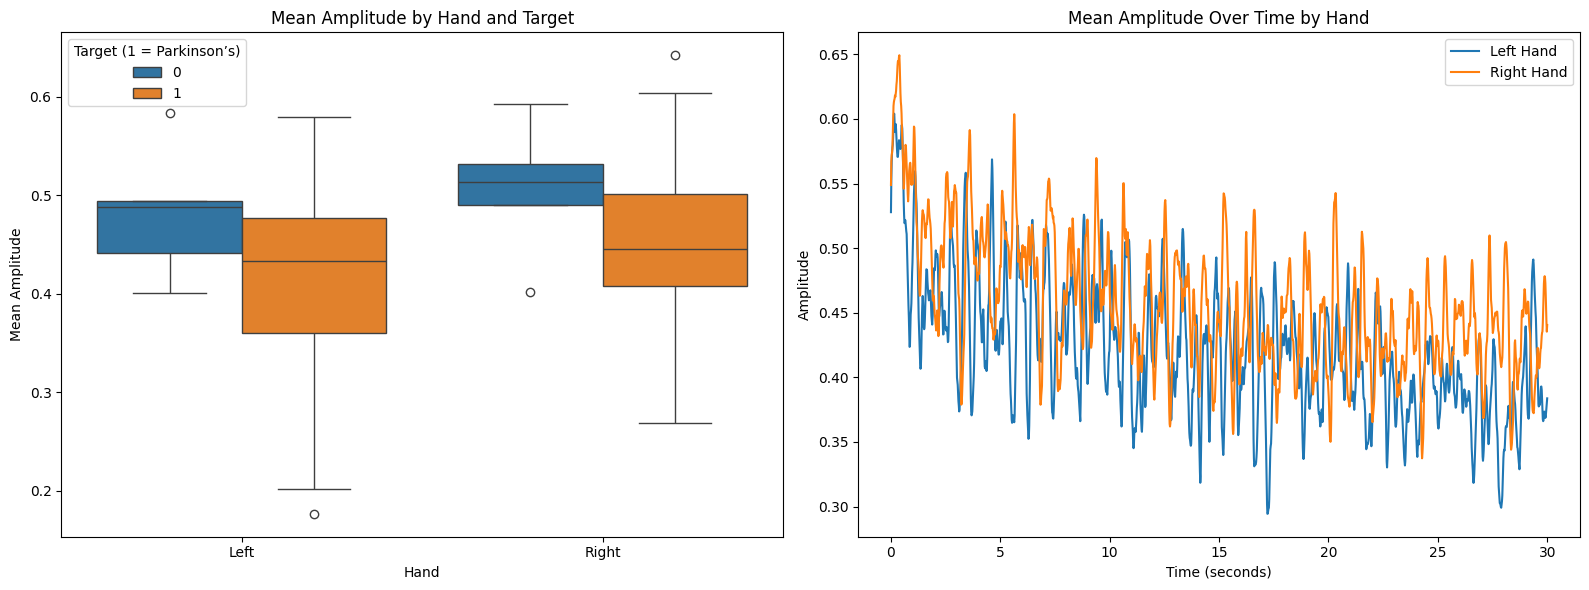

In [ ]:

# ---------- Prepare data ----------
left_df = left_df.copy()
right_df = right_df.copy()

left_df["hand"] = "Left"
right_df["hand"] = "Right"

# Mean amplitude per patient
left_df["mean_amplitude"] = left_df["amplitude"].apply(np.mean)
right_df["mean_amplitude"] = right_df["amplitude"].apply(np.mean)

combined_df = pd.concat([left_df, right_df], ignore_index=True)

# ---------- Mean amplitude over time ----------
def mean_amplitude_over_time(df):
    # stack padded signals: (n_patients, 1800)
    stacked = np.vstack(df["amplitude"].values)
    return np.mean(stacked, axis=0)

left_mean_curve = mean_amplitude_over_time(left_df)
right_mean_curve = mean_amplitude_over_time(right_df)

# Time axis (ends at 30s as you observed)
time_axis = np.linspace(0, 30, len(left_mean_curve))

# ---------- Plot ----------
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# (1) Mean amplitude by hand and target
sns.boxplot(
    data=combined_df,
    x="hand",
    y="mean_amplitude",
    hue="target",
    ax=axes[0]
)
axes[0].set_title("Mean Amplitude by Hand and Target")
axes[0].set_xlabel("Hand")
axes[0].set_ylabel("Mean Amplitude")
axes[0].legend(title="Target (1 = Parkinson’s)")

# (2) Mean amplitude over time by hand
axes[1].plot(time_axis, left_mean_curve, label="Left Hand")
axes[1].plot(time_axis, right_mean_curve, label="Right Hand")
axes[1].set_title("Mean Amplitude Over Time by Hand")
axes[1].set_xlabel("Time (seconds)")
axes[1].set_ylabel("Amplitude")
axes[1].legend()

plt.tight_layout()
plt.show()

# Feature Engineering


In [ ]:
# Cell 1 — Load + parse data (binary labels already encoded)
LEFT_CSV_PATH  = "/content/drive/MyDrive/DSAIP/dataset/left_hand_dataset.csv"
RIGHT_CSV_PATH = "/content/drive/MyDrive/DSAIP/dataset/right_hand_dataset.csv"

left_df = pd.read_csv(LEFT_CSV_PATH)
right_df = pd.read_csv(RIGHT_CSV_PATH)

def _ensure_list(x):
    """
    CSV saves lists as strings, e.g. "[0.1, 0.2, ...]".
    Convert string -> Python list safely.
    """
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        return ast.literal_eval(x)
    return list(x)

for df in [left_df, right_df]:
    df["amplitude"] = df["amplitude"].apply(_ensure_list)
    df["time"] = df["time"].apply(_ensure_list)

# IMPORTANT:
# updrs_left / updrs_right are ALREADY binary labels (0/1) derived from rater averages.
left_df["target"] = left_df["updrs_left"].astype(int)
right_df["target"] = right_df["updrs_right"].astype(int)

# Optional: ID-based label as a sanity check
left_df["target_id"]  = left_df["patient_id"].apply(lambda x: 1 if str(x).startswith("PD") else 0)
right_df["target_id"] = right_df["patient_id"].apply(lambda x: 1 if str(x).startswith("PD") else 0)

# Quick dataset sanity checks
def summarize_lengths(df, name):
    amp_lens = df["amplitude"].apply(len)
    time_lens = df["time"].apply(len)
    print(f"\n{name} — rows: {len(df)}")
    print("Amplitude length summary:\n", amp_lens.describe())
    print("Time length summary:\n", time_lens.describe())

summarize_lengths(left_df, "LEFT")
summarize_lengths(right_df, "RIGHT")

print("\nClass balance (binary labels from rating sheet):")
print("LEFT target counts:\n", left_df["target"].value_counts())
print("RIGHT target counts:\n", right_df["target"].value_counts())

print("\nLabel agreement check (ID vs provided binary labels):")
print("LEFT mismatches:", (left_df["target_id"] != left_df["target"]).sum())
print("RIGHT mismatches:", (right_df["target_id"] != right_df["target"]).sum())



LEFT — rows: 66
Amplitude length summary:
 count      66.0
mean     1800.0
std         0.0
min      1800.0
25%      1800.0
50%      1800.0
75%      1800.0
max      1800.0
Name: amplitude, dtype: float64
Time length summary:
 count      66.0
mean     1800.0
std         0.0
min      1800.0
25%      1800.0
50%      1800.0
75%      1800.0
max      1800.0
Name: time, dtype: float64

RIGHT — rows: 66
Amplitude length summary:
 count      66.0
mean     1800.0
std         0.0
min      1800.0
25%      1800.0
50%      1800.0
75%      1800.0
max      1800.0
Name: amplitude, dtype: float64
Time length summary:
 count      66.0
mean     1800.0
std         0.0
min      1800.0
25%      1800.0
50%      1800.0
75%      1800.0
max      1800.0
Name: time, dtype: float64

Class balance (binary labels from rating sheet):
LEFT target counts:
 target
0    48
1    18
Name: count, dtype: int64
RIGHT target counts:
 target
0    52
1    14
Name: count, dtype: int64

Label agreement check (ID vs provided binary 

In [ ]:
# Signal preprocessing

def preprocess_signal(
    amplitude,
    window_length=7,
    polyorder=2,
    apply_filter=True
):
    """
    Light preprocessing for finger tapping amplitude signals.

    Parameters:
    - amplitude: list or np.array of raw amplitude values
    - window_length: Savitzky–Golay window (must be odd)
    - polyorder: polynomial order for smoothing
    - apply_filter: whether to apply smoothing

    Returns:
    - processed_amplitude: np.array
    """
    amplitude = np.asarray(amplitude, dtype=float)

    if apply_filter:
        # Safety: window must be < signal length and odd
        if window_length >= len(amplitude):
            window_length = len(amplitude) - 1
        if window_length % 2 == 0:
            window_length += 1

        amplitude = savgol_filter(
            amplitude,
            window_length=window_length,
            polyorder=polyorder
        )

    return amplitude


In [ ]:
# Checking results of singal processing

raw = left_df.loc[0, "amplitude"]
filtered = preprocess_signal(raw)

print("Raw first 10:", raw[:10])
print("Filtered first 10:", filtered[:10])


Raw first 10: [0.7659240331883278, 0.8466510181877207, 0.8836184324652063, 0.8886561514576128, 0.8916548254547423, 0.8808234891333857, 0.8818029806041867, 0.8917539960419272, 0.9086820201248781, 0.9099645127194539]
Filtered first 10: [0.77909954 0.83244598 0.87051124 0.89329534 0.88942456 0.88395909
 0.88627881 0.89450605 0.90385112 0.90425436]


In [ ]:
# Robust peak detection (ignores padded time issues)

def extract_peaks(
    amplitude,
    time,
    prominence_ratio=0.1,
    min_interval_sec=0.15,
    fallback_duration_sec=30.0
):
    """
    Adaptive peak detection, robust to time arrays that have repeated values
    (e.g., padding). Uses inferred dt from time if valid; otherwise falls back
    to duration/len(amplitude).
    """
    amplitude = np.asarray(amplitude, dtype=float)
    time = np.asarray(time, dtype=float)

    # Try to infer dt from time, but guard against duplicates/padding
    diffs = np.diff(time)
    diffs = diffs[diffs > 0]  # keep only strictly positive steps

    if len(diffs) > 0:
        dt = np.median(diffs)
    else:
        # Fallback: assume fixed duration across 1800 samples
        dt = fallback_duration_sec / len(amplitude)

    # Convert min interval to samples; clamp to at least 1
    min_distance_samples = max(1, int(min_interval_sec / dt))

    # Adaptive prominence
    signal_range = np.max(amplitude) - np.min(amplitude)
    prominence = prominence_ratio * signal_range

    peaks, properties = find_peaks(
        amplitude,
        prominence=prominence,
        distance=min_distance_samples
    )

    peak_amplitudes = amplitude[peaks]
    peak_times = time[peaks]  # OK even if time has repeats; we handle ITIs later safely

    return peaks, peak_amplitudes, peak_times


In [ ]:
# Checking the results of peak detection

idx = 0  # try a few different indices later
amp = preprocess_signal(left_df.loc[idx, "amplitude"])
t = np.array(left_df.loc[idx, "time"])

peaks, peak_amps, peak_times = extract_peaks(amp, t)

print("Number of taps detected:", len(peaks))
print("First 5 peak amplitudes:", peak_amps[:5])
print("First 5 ITIs:", np.diff(peak_times)[:5])


Number of taps detected: 63
First 5 peak amplitudes: [0.93835046 0.88340481 0.87760308 0.94876563 0.94999431]
First 5 ITIs: [0.81666667 0.46666667 0.55       0.41666667 0.46666667]


In [ ]:
# Robust feature extraction (ITI from indices if needed)

def extract_features_from_signal(
    amplitude,
    time,
    early_frac=0.2,
    min_early_peaks=3,
    fallback_duration_sec=30.0
):
    amp = preprocess_signal(amplitude)
    t = np.asarray(time, dtype=float)

    peaks, peak_amps, peak_times = extract_peaks(amp, t, fallback_duration_sec=fallback_duration_sec)

    if len(peak_amps) < 5:
        return {
            "num_taps": np.nan,
            "mean_peak_amp": np.nan,
            "std_peak_amp": np.nan,
            "amp_decrement": np.nan,
            "mean_iti": np.nan,
            "std_iti": np.nan,
            "cv_iti": np.nan,
            "num_long_pauses": np.nan,
            "prop_long_pauses": np.nan,
        }

    features = {}
    features["num_taps"] = len(peak_amps)

    features["mean_peak_amp"] = np.mean(peak_amps)
    features["std_peak_amp"] = np.std(peak_amps)

    n_early = max(min_early_peaks, int(early_frac * len(peak_amps)))
    early_mean = np.mean(peak_amps[:n_early])
    late_mean = np.mean(peak_amps[-n_early:])
    features["amp_decrement"] = early_mean - late_mean

    # Robust dt inference
    diffs = np.diff(t)
    diffs = diffs[diffs > 0]
    if len(diffs) > 0:
        dt = np.median(diffs)
    else:
        dt = fallback_duration_sec / len(amp)

    # ITI from peak index differences (more reliable than time if time has repeats)
    peak_index_diffs = np.diff(peaks)
    itis = peak_index_diffs * dt

    features["mean_iti"] = np.mean(itis)
    features["std_iti"] = np.std(itis)
    features["cv_iti"] = features["std_iti"] / features["mean_iti"] if features["mean_iti"] > 0 else np.nan

    median_iti = np.median(itis)
    long_pauses = itis > (1.5 * median_iti)
    features["num_long_pauses"] = int(np.sum(long_pauses))
    features["prop_long_pauses"] = float(np.mean(long_pauses))

    return features


In [ ]:
# Checking the results of feature extraction

feat_test = extract_features_from_signal(
    left_df.loc[0, "amplitude"],
    left_df.loc[0, "time"]
)

feat_test


{'num_taps': 63,
 'mean_peak_amp': np.float64(0.9088938602725635),
 'std_peak_amp': np.float64(0.04814833991498387),
 'amp_decrement': np.float64(0.04918198906293447),
 'mean_iti': np.float64(0.45268817204300915),
 'std_iti': np.float64(0.060478494384685826),
 'cv_iti': np.float64(0.13359857429396205),
 'num_long_pauses': 1,
 'prop_long_pauses': 0.016129032258064516}

In [ ]:
# Cell 5 — Build feature tables (binary labels already encoded)

def build_feature_table(df, hand="left"):
    """
    Build a feature table from a dataframe containing
    amplitude, time, updrs_left/updrs_right and target columns.
    """
    feature_rows = []

    for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Extracting {hand} features"):
        features = extract_features_from_signal(
            row["amplitude"],
            row["time"]
        )

        # Attach identifiers and labels
        features["patient_id"] = row["patient_id"]
        features["hand"] = hand

        if hand == "left":
            features["updrs"] = int(row["updrs_left"])   # binary label from rating sheet
            features["target"] = int(row["target"])
        else:
            features["updrs"] = int(row["updrs_right"])  # binary label from rating sheet
            features["target"] = int(row["target"])

        feature_rows.append(features)

    return pd.DataFrame(feature_rows)

# Build feature tables
left_features_df = build_feature_table(left_df, hand="left")
right_features_df = build_feature_table(right_df, hand="right")

# Sanity checks
print("LEFT features shape:", left_features_df.shape)
print("RIGHT features shape:", right_features_df.shape)

print("\nLEFT feature-table class balance:")
print(left_features_df["target"].value_counts())

print("\nRIGHT feature-table class balance:")
print(right_features_df["target"].value_counts())

left_features_df.head()


Extracting right features: 100%|██████████| 66/66 [00:00<00:00, 643.86it/s]

LEFT features shape: (66, 13)
RIGHT features shape: (66, 13)

LEFT feature-table class balance:
target
0    48
1    18
Name: count, dtype: int64

RIGHT feature-table class balance:
target
0    52
1    14
Name: count, dtype: int64


,num_taps,mean_peak_amp,std_peak_amp,amp_decrement,mean_iti,std_iti,cv_iti,num_long_pauses,prop_long_pauses,patient_id,hand,updrs,target
0,63,0.908894,0.048148,0.049182,0.452688,0.060478,0.133599,1,0.016129,C35,left,0,0
1,52,0.895847,0.043548,0.055189,0.542157,0.059807,0.110312,0,0.000000,C34,left,0,0
2,68,0.895318,0.120084,0.097290,0.421891,0.067728,0.160536,0,0.000000,C36,left,0,0
3,55,0.904132,0.066108,-0.025667,0.538580,0.108242,0.200976,0,0.000000,PD0,left,0,0
4,57,0.807915,0.192839,0.059099,0.522619,0.174785,0.334441,1,0.017857,C37,left,0,0


In [ ]:
# Find rows where time has duplicate steps / padding artifacts

'''This diagnostic identifies recordings where the time vector is not strictly increasing due to padding with repeated end values (e.g. 30.0s).
These signals are not corrupted; padding occurs after the movement window.
Feature extraction therefore avoids relying on raw time differences and instead uses robust index-based timing.'''

def time_has_issues(t):
    t = np.asarray(t, dtype=float)
    return np.any(np.diff(t) <= 0)

bad_left = left_df[left_df["time"].apply(time_has_issues)]
bad_right = right_df[right_df["time"].apply(time_has_issues)]

print("Bad LEFT rows:", len(bad_left))
print("Bad RIGHT rows:", len(bad_right))


Bad LEFT rows: 46
Bad RIGHT rows: 42


/tmp/ipython-input-1411552443.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Healthy (UPDRS 0–1)", "PD (UPDRS 2–4)"])
/tmp/ipython-input-1411552443.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Healthy (UPDRS 0–1)", "PD (UPDRS 2–4)"])
/tmp/ipython-input-1411552443.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Healthy (UPDRS 0–1)", "PD (UPDRS 2–4)"])
/tmp/ipython-input-1411552443.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(["Healthy (UPDRS 0–1)", "PD (UPDRS 2–4)"])


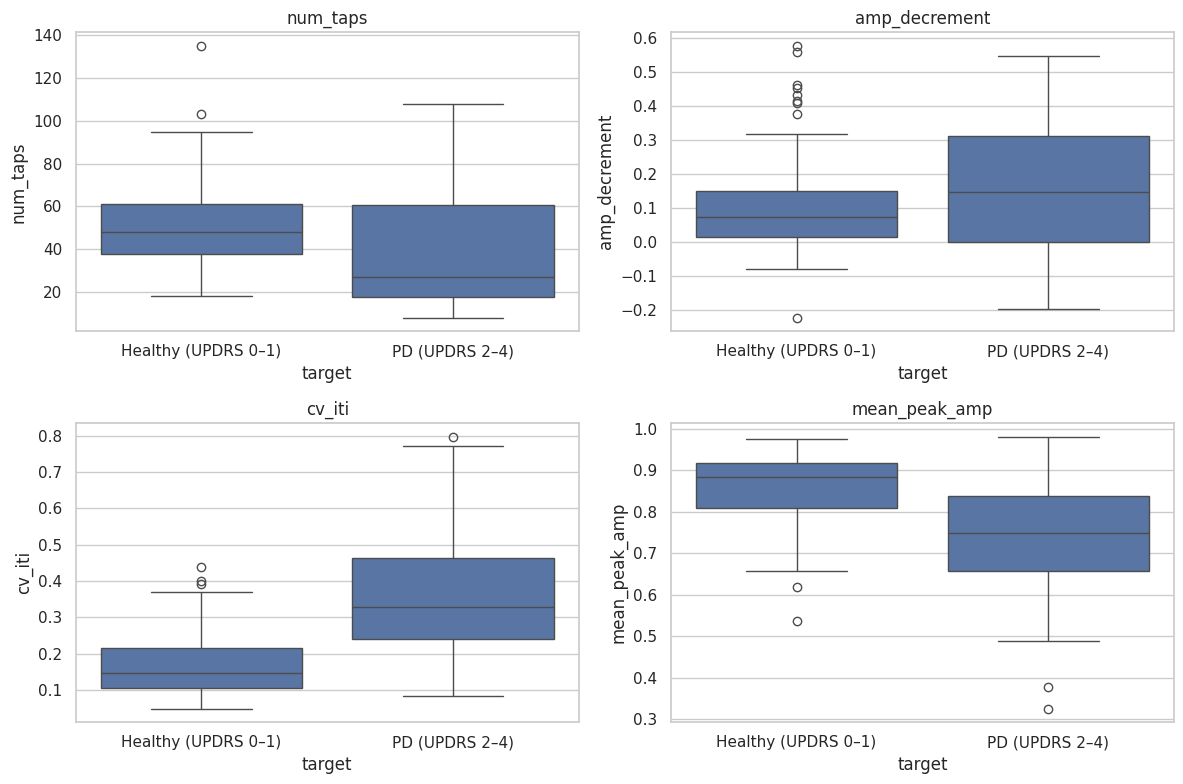

In [ ]:
# FIXED validation plots (ensure both classes show)

features_df = pd.concat([left_features_df, right_features_df], ignore_index=True)

# Make sure target is numeric
features_df["target"] = features_df["target"].astype(int)

key_features = ["num_taps", "amp_decrement", "cv_iti", "mean_peak_amp"]

import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.flatten()

for ax, feature in zip(axes, key_features):
    sns.boxplot(
        data=features_df,
        x="target",
        y=feature,
        ax=ax
    )
    ax.set_xticklabels(["Healthy (UPDRS 0–1)", "PD (UPDRS 2–4)"])
    ax.set_title(feature)

plt.tight_layout()
plt.show()


In [ ]:
# Export feature tables to CSV (for modelling)


LEFT_OUT_PATH  = "/content/drive/MyDrive/DSAIP/dataset/left_hand_features.csv"
RIGHT_OUT_PATH = "/content/drive/MyDrive/DSAIP/dataset/right_hand_features.csv"

left_features_df.to_csv(LEFT_OUT_PATH, index=False)
right_features_df.to_csv(RIGHT_OUT_PATH, index=False)

print("Saved feature tables:")
print(" -", LEFT_OUT_PATH)
print(" -", RIGHT_OUT_PATH)

Saved feature tables:
 - /content/drive/MyDrive/DSAIP/dataset/left_hand_features.csv
 - /content/drive/MyDrive/DSAIP/dataset/right_hand_features.csv



## Model Development

This section implements two clinically justifiable machine learning models for Parkinson’s Disease motor assessment using finger tapping features:
- **Primary model:** Random Forest Classifier (interpretable, robust to noise)
- **Secondary model:** Support Vector Machine with RBF kernel (strong non-linear benchmark)

Models are trained **separately for left and right hand feature sets** using **Stratified k-Fold Cross-Validation** to ensure balanced class representation.


In [ ]:
left_features_df.columns

Index(['num_taps', 'mean_peak_amp', 'std_peak_amp', 'amp_decrement',
       'mean_iti', 'std_iti', 'cv_iti', 'num_long_pauses', 'prop_long_pauses',
       'patient_id', 'hand', 'updrs', 'target'],
      dtype='object')

In [ ]:


def evaluate_svm(df, hand_label):
    X = df.drop(columns=['target', 'patient_id', 'hand'])
    y = df['target']

    feature_cols = X.columns

    # Stratified k-fold cross-validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    svm_pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', SVC(
            kernel='rbf',
            C=0.5,
            gamma='scale',
            class_weight='balanced',
            probability=True,
            random_state=42
        ))
    ])

    # Cross-validated metrics
    scores = cross_validate(
        svm_pipeline, X, y, cv=skf,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc'
        }
    )

    print(f"\n===== {hand_label} Hand SVM Evaluation =====")
    print(f"Accuracy : {np.mean(scores['test_accuracy']):.2f}")
    print(f"Precision: {np.mean(scores['test_precision']):.2f}")
    print(f"Recall   : {np.mean(scores['test_recall']):.2f}")
    print(f"F1 Score : {np.mean(scores['test_f1']):.2f}")
    print(f"ROC-AUC  : {np.mean(scores['test_roc_auc']):.2f}")

    # Predictions for confusion matrix & report
    y_pred = cross_val_predict(svm_pipeline, X, y, cv=skf)
    y_prob = cross_val_predict(svm_pipeline, X, y, cv=skf, method='predict_proba')[:, 1]

    print("\nConfusion Matrix:")
    print(confusion_matrix(y, y_pred))

    print("\nClassification Report:")
    print(classification_report(y, y_pred))

    print(f"ROC-AUC (pooled): {roc_auc_score(y, y_prob):.2f}")

    # Safety uncertainty band
    def classify_with_uncertainty(p):
        if p < 0.40:
            return 0
        elif p > 0.50:
            return 1
        else:
            return -1   # unsure

    safe_preds = np.array([classify_with_uncertainty(p) for p in y_prob])
    unsure_rate = np.mean(safe_preds == -1)
    print(f"\nUncertainty Rate: {unsure_rate:.2f}")

    # ==============================
    # SAVE MODEL
    # ==============================
    model_path = os.path.join(MODEL_DIR, f"svm_{hand_label.lower()}.pkl")

    # Fit the full pipeline on all data before saving
    svm_pipeline.fit(X, y)

    joblib.dump(svm_pipeline, model_path)

    print("\nSaved:")
    print(model_path)

# Evaluate both hands
evaluate_svm(left_features_df, "Left")
evaluate_svm(right_features_df, "Right")


===== Left Hand SVM Evaluation =====
Accuracy : 0.99
Precision: 0.96
Recall   : 1.00
F1 Score : 0.98
ROC-AUC  : 1.00

Confusion Matrix:
[[47  1]
 [ 0 18]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        48
           1       0.95      1.00      0.97        18

    accuracy                           0.98        66
   macro avg       0.97      0.99      0.98        66
weighted avg       0.99      0.98      0.98        66

ROC-AUC (pooled): 1.00

Uncertainty Rate: 0.00

Saved:
/content/drive/MyDrive/DSAIP/streamlit/models/svm_left.pkl

===== Right Hand SVM Evaluation =====
Accuracy : 0.95
Precision: 0.87
Recall   : 1.00
F1 Score : 0.92
ROC-AUC  : 0.99

Confusion Matrix:
[[49  3]
 [ 0 14]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97        52
           1       0.82      1.00      0.90        14

    accuracy                      